# Build a Recurrent Neural Network

In our online courses, we learnt a lot of useful concepts in ML, like regression, logistic, SVM, CNN. In this project, we wanna simply emplore some other domains. Try to get the theory and play with it a little bit. After checked some materials, we found an interesting demo related to RNN.

Introduction: We have learned that neural networks can be regarded as a black box that can fit any function. As long as the training data is enough, given a specific x, we can get the desired y. Unfortunately, it can only take and process the input one by one, and the former input has nothing to do with the latter. However, some tasks need to be able to process the sequence information better, that is, the previous input is related to the later input. 

For a simple example, when we see a name "Harry Potter", we can blurt it out. However, if it is the reverse of “Potter Harry", it will not be so easy. This shows how important sequencing is for forecasting. We can predict the next word in a certain order, but we can't analyze what we're talking about by disorder. 

In order to make the neural network analyze the relationship between the upper and lower problems like people, we hope that the neural network also has the ability to remember the previous events. When analyzing Data0, we store the analysis results in memory. When analyzing data1, NN will generate new memory and we simply call the old memory and analyze it together. If we continue to analyze more ordered data, RNN will accumulate all previous memories and analyze them together. For example sentiment classification, speech recognition, hand writing recognition, grammar learning.

This site provides a simple code to build RNN from scatch and use it to predict sine wave.
https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/
We try to rebuild it and use it to do some other kinds of prediction.

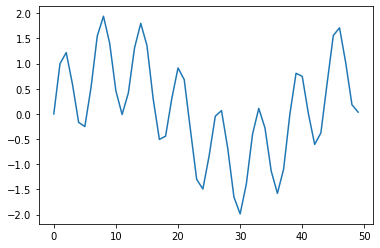

In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
wave =(np.array([math.sin(x) + math.sin(math.pi*x*0.05) for x in np.arange(0,200)]))
# Here, we are using our self-generated curve, and try to find its trend by our model.
plt.plot(wave[:50])

In [2]:
X = []
Y = []

seq_len = 50
num_records = len(wave) - seq_len

for i in range(num_records - 50):
    X.append(wave[i:i+seq_len])
    Y.append(wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [3]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [4]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(wave[i:i+seq_len])
    Y_val.append(wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

Find best learning rate in these five numbers.

In [28]:
learning_rates = [0.0002,0.0001,0.00007,0.00005,0.00003]    
nepoch = 35             
T = 50                  # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [30]:
hist_tr = []
hist_ts = []
test_score = np.ones(5)
Us = []
Ws = []
Vs = []
for ith,learning_rate in enumerate(learning_rates):
    hist_loss_tr = []
    hist_loss_ts = []
    U = np.random.uniform(0, 1, (hidden_dim, T))
    W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
    V = np.random.uniform(0, 1, (output_dim, hidden_dim))
    print('-----Current rate is ' + str(learning_rate) + ' -----')
    for epoch in range(nepoch):
        # check loss on train
        loss = 0.0

        # do a forward pass to get prediction
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]                    # get input, output values of each record
            prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
            for t in range(T):
                new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
                new_input[t] = x[t]              # for this, we define a single input for that timestep
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                prev_s = s

        # calculate error 
            loss_per_record = (y - mulv)**2 / 2
            loss += loss_per_record
        loss = loss / float(y.shape[0])
        hist_loss_tr.append(loss[0][0])
        # check loss on val
        val_loss = 0.0
        for i in range(Y_val.shape[0]):
            x, y = X_val[i], Y_val[i]
            prev_s = np.zeros((hidden_dim, 1))
            for t in range(T):
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                prev_s = s

            loss_per_record = (y - mulv)**2 / 2
            val_loss += loss_per_record
        val_loss = val_loss / float(y.shape[0])
        hist_loss_ts.append(val_loss[0][0])
        if (epoch+1) % 7 == 0 or epoch == 0:
            print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
        # train model
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]

            layers = []
            prev_s = np.zeros((hidden_dim, 1))
            dU = np.zeros(U.shape)
            dV = np.zeros(V.shape)
            dW = np.zeros(W.shape)

            dU_t = np.zeros(U.shape)
            dV_t = np.zeros(V.shape)
            dW_t = np.zeros(W.shape)

            dU_i = np.zeros(U.shape)
            dW_i = np.zeros(W.shape)

            # forward pass
            for t in range(T):
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                layers.append({'s':s, 'prev_s':prev_s})
                prev_s = s
            # derivative of pred
            dmulv = (mulv - y)

            # backward pass
            for t in range(T):
                dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
                dsv = np.dot(np.transpose(V), dmulv)

                ds = dsv
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)

                dprev_s = np.dot(np.transpose(W), dmulw)


                for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                    ds = dsv + dprev_s
                    dadd = add * (1 - add) * ds

                    dmulw = dadd * np.ones_like(mulw)
                    dmulu = dadd * np.ones_like(mulu)

                    dW_i = np.dot(W, layers[t]['prev_s'])
                    dprev_s = np.dot(np.transpose(W), dmulw)

                    new_input = np.zeros(x.shape)
                    new_input[t] = x[t]
                    dU_i = np.dot(U, new_input)
                    dx = np.dot(np.transpose(U), dmulu)

                    dU_t += dU_i
                    dW_t += dW_i

                dV += dV_t
                dU += dU_t
                dW += dW_t
                if dU.max() > max_clip_value:
                    dU[dU > max_clip_value] = max_clip_value
                if dV.max() > max_clip_value:
                    dV[dV > max_clip_value] = max_clip_value
                if dW.max() > max_clip_value:
                    dW[dW > max_clip_value] = max_clip_value


                if dU.min() < min_clip_value:
                    dU[dU < min_clip_value] = min_clip_value
                if dV.min() < min_clip_value:
                    dV[dV < min_clip_value] = min_clip_value
                if dW.min() < min_clip_value:
                    dW[dW < min_clip_value] = min_clip_value

            # update
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    hist_tr.append(hist_loss_tr)
    hist_ts.append(hist_loss_ts)
    test_score[ith] = hist_loss_ts[-1]
    Us.append(U)
    Ws.append(W)
    Vs.append(V)

-----Current rate is 0.0002 -----
Epoch:  1 , Loss:  [[136112.96576436]] , Val Loss:  [[68437.37578324]]
Epoch:  7 , Loss:  [[62.77861508]] , Val Loss:  [[28.54677687]]
Epoch:  14 , Loss:  [[61.97312475]] , Val Loss:  [[29.27300908]]
Epoch:  21 , Loss:  [[63.2450812]] , Val Loss:  [[30.2267506]]
Epoch:  28 , Loss:  [[70.18046382]] , Val Loss:  [[31.78484383]]
Epoch:  35 , Loss:  [[72.66862512]] , Val Loss:  [[33.10059816]]
-----Current rate is 0.0001 -----
Epoch:  1 , Loss:  [[135951.80349197]] , Val Loss:  [[68356.5686021]]
Epoch:  7 , Loss:  [[48.41077319]] , Val Loss:  [[22.76095947]]
Epoch:  14 , Loss:  [[48.02162517]] , Val Loss:  [[22.76402981]]
Epoch:  21 , Loss:  [[48.51115091]] , Val Loss:  [[22.80753318]]
Epoch:  28 , Loss:  [[48.90209865]] , Val Loss:  [[22.93959007]]
Epoch:  35 , Loss:  [[49.42072818]] , Val Loss:  [[23.25950296]]
-----Current rate is 7e-05 -----
Epoch:  1 , Loss:  [[114099.4543194]] , Val Loss:  [[57398.39221199]]
Epoch:  7 , Loss:  [[1599.46773463]] , Val

Best learning rate is 0.0001, with test loss 23.25950295925264


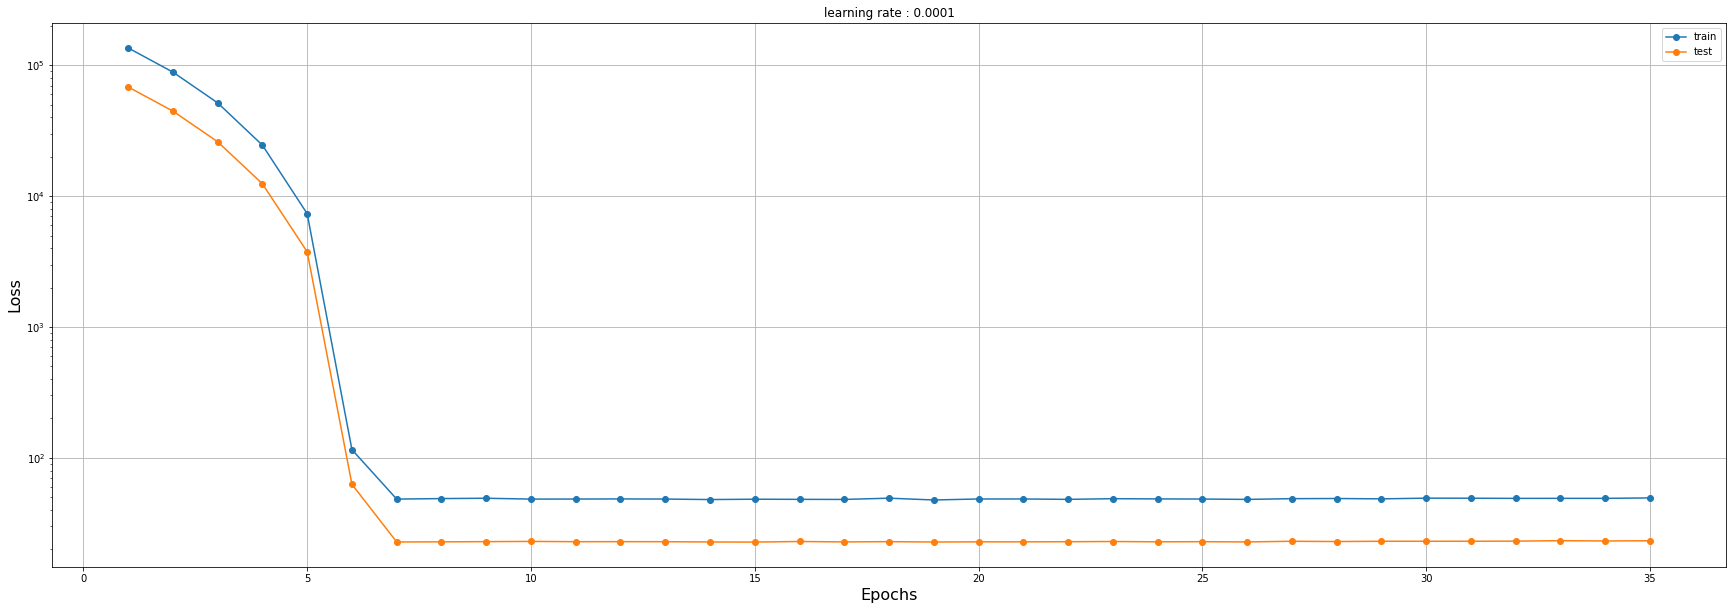

In [31]:
# plot trainning curve
index = np.argmin(test_score)
print('Best learning rate is ' + str(learning_rates[index]) + ', with test loss ' + str(test_score[index]))
epochs = np.arange(1,36)
plt.figure(figsize=(30,10))
plt.semilogy(epochs, hist_tr[index], 'o-')
plt.semilogy(epochs, hist_ts[index], 'o-')
plt.xlabel('Epochs', fontsize=16) 
plt.ylabel('Loss', fontsize=16)
plt.legend(['train','test'])
plt.title('learning rate : ' + str(learning_rates[index]))
plt.grid()

Check the predicted curve with trainning set.

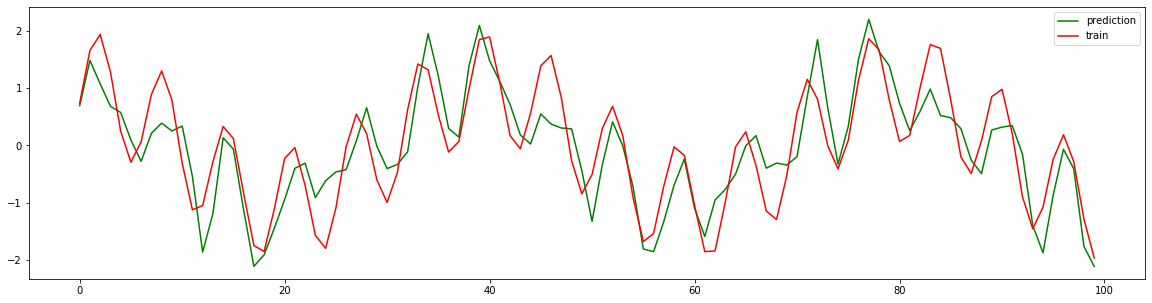

In [34]:
U = Us[index]
V = Vs[index]
W = Ws[index]
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)
plt.figure(figsize=(20,5))
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.legend(['prediction','train'])
plt.show()

check the predicted curve with testing set.

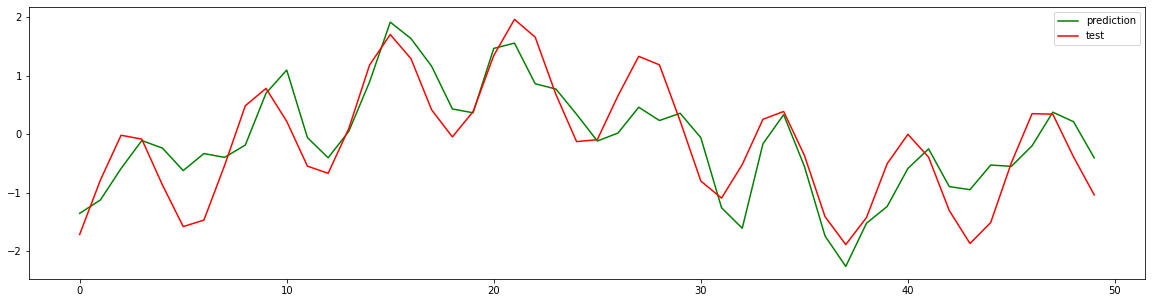

In [35]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)
plt.figure(figsize=(20,5))
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.legend(['prediction','test'])
plt.show()

Conclusion: The predicted curve has the same trend mostly with the trainning and testing sets. That means, our RNN model is able to find the underlying feature of our input curve.